In [1]:
from typing import Callable, Any, Dict

import lightning as L
import torch
import torchmetrics
# from pl_bolts.optimizers import LinearWarmupCosineAnnealingLR
from torch import nn

from cellm.components.cell_to_cell import CellToCellPytorchTransformer
from cellm.components.cell_to_output import CellToOutputMLP
from cellm.components.gene_to_cell import GeneToCellLinear
from cellm.components.masking import Masking
from cellm.data.data_structures import CellSample
import pickle
import scipy.stats
import pandas as pd
import numpy as np

from rep_exp_utils import CellClassifyModel

In [2]:
import os
from typing import List, Optional

import torch
from lightning import LightningDataModule

#from scimilarity_gred.tiledb_sample_data_models import SampleCellsDataModule_disease, scDataset_disease
from cellm.data.data_scimilarity_gred import SampleCellsDataModule_disease, scDataset_disease
from torch.utils.data import Dataset, DataLoader

# from cellm.data.data_structures import CellSample
import pickle

from dataclasses import dataclass

import torch
import json
import sklearn

In [3]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import LRP
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule, Alpha1_Beta0_Rule

/home/debroue1/scratch/conda/envs/pascient/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def most_frequent_per_row(array):
    most_frequent_values = []
    for row in array:
        counts = np.bincount(row)
        most_frequent = np.argmax(counts)
        most_frequent_values.append(most_frequent)
    return np.array(most_frequent_values)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
f1score_list = []
finalauroc_list = []
from sklearn.metrics import classification_report #1e-3, best save
from sklearn.metrics import roc_auc_score

os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
os.environ["WORLD_SIZE"] = "1"

class_model = CellClassifyModel.load_from_checkpoint("/projects/site/gred/resbioai/liut61/disease_class/disease2classlr1e3wd1e4batch32epoch50_weightaverage_dim1-epoch=36-val_accuracy=0.82.ckpt", num_genes=28231, masking_strategy=None, attn = 'linear_attn')
ig = IntegratedGradients(class_model)

/home/debroue1/scratch/conda/envs/pascient/lib/python3.11/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


2


In [6]:
import scanpy as sc
adata = sc.read_h5ad("/projects/site/gred/resbioai/liut61/combined_4dataset_processed_data.h5ad")
gene_list = pd.read_csv("/gstore/data/omni/scdb/cleaned_h5ads/gene_order.tsv", header=None)
gene_list = gene_list[0].values

/home/debroue1/scratch/conda/envs/pascient/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [7]:
adata_new = sc.AnnData(np.zeros((1,len(gene_list))))
adata_new.var_names = gene_list
adata_c = sc.concat([adata_new, adata], join='outer', label='batch_new')

adata_c_f = adata_c[adata_c.obs['batch_new'] == '1']
adata_c_f = adata_c_f[:, gene_list]
adata_c_f.obs['sampleID']

GSM4557327_CTTACTCCTATC    28205-0555d0./stanford_obj.h5ad
GSM4557327_GCCCTAAACTTT    28205-0555d0./stanford_obj.h5ad
GSM4557327_AGTGTGTTCTGG    28205-0555d0./stanford_obj.h5ad
GSM4557327_CGAGATAGGGTG    28205-0555d0./stanford_obj.h5ad
GSM4557327_GAGATGCGCTTA    28205-0555d0./stanford_obj.h5ad
                                        ...               
TTTGTTGAGGTACATA-20                    20./korean_obj.h5ad
TTTGTTGAGTACTGGG-20                    20./korean_obj.h5ad
TTTGTTGAGTGCACAG-20                    20./korean_obj.h5ad
TTTGTTGCATCATTTC-20                    20./korean_obj.h5ad
TTTGTTGTCTGCTTAT-20                    20./korean_obj.h5ad
Name: sampleID, Length: 278920, dtype: category
Categories (116, object): ['1./korean_obj.h5ad', '2./korean_obj.h5ad', '9./korean_obj.h5ad', '10./korean_obj.h5ad', ..., 'C19-CB-0199_d8./berlin_obj.h5ad', 'C19-CB-0204_d15./berlin_obj.h5ad', 'C19-CB-0214_d7./berlin_obj.h5ad', 'EC003./stanford_obj.h5ad']

/tmp/ipykernel_2164094/3305415282.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dis_label.append(adata_s.obs['condition'][0])


RanksumsResult(statistic=-4.348954069189178, pvalue=6.839417729125783e-06)


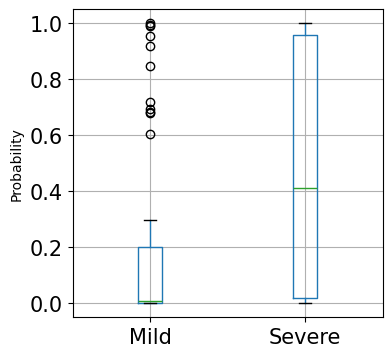

In [8]:
if torch.cuda.is_available():
    sample_data_list = []
    dis_label = []
    with torch.no_grad():
        for item in adata_c_f.obs['sampleID'].unique():
            adata_s = adata_c_f[adata_c_f.obs['sampleID'] == item]
            input_data = adata_s.X.toarray().reshape(1,  adata_s.X.shape[0], adata_s.X.shape[1])
            query = torch.FloatTensor(input_data).cuda()
            sample_data,probs = class_model.obtain_annotation_directly(query)
            sample_data_list.append(probs.cpu().numpy())
            dis_label.append(adata_s.obs['condition'][0])
else:
    sample_data_list = []
    dis_label = []
    with torch.no_grad():
        for item in adata_c_f.obs['sampleID'].unique():
            adata_s = adata_c_f[adata_c_f.obs['sampleID'] == item]
            input_data = adata_s.X.toarray().reshape(1,  adata_s.X.shape[0], adata_s.X.shape[1])
            query = torch.FloatTensor(input_data)
            sample_data,probs = class_model.obtain_annotation_directly(query)
            sample_data_list.append(probs.cpu().numpy())
            dis_label.append(adata_s.obs['condition'][0])

healthy_average = []
disease_average = []
for i,j in zip(sample_data_list,dis_label):
    if j == 'Mild':
        healthy_average.append(i[0][1])
    else:
        disease_average.append(i[0][1])


print(scipy.stats.ranksums(healthy_average, disease_average, alternative='less'))


df1 = pd.DataFrame({'Mild':healthy_average})
df2 = pd.DataFrame({'Severe':disease_average})



df = pd.concat([df1, df2])


df.boxplot(figsize=(4,4), fontsize=15)
plt.ylabel('Probability')
plt.show()

/tmp/ipykernel_2164094/596429134.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dis_label.append(adata_s.obs['condition'][0])


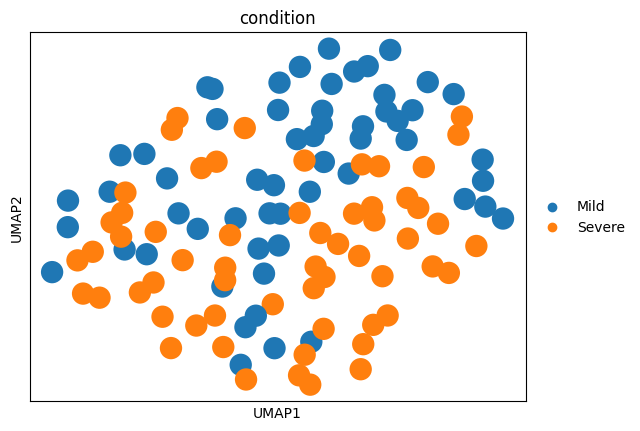

In [14]:
if torch.cuda.is_available():
    sample_data_list = []
    dis_label = []
    study_label = []
    with torch.no_grad():
        for item in adata_c_f.obs['sampleID'].unique():
            adata_s = adata_c_f[adata_c_f.obs['sampleID'] == item]
            input_data = adata_s.X.toarray().reshape(1,  adata_s.X.shape[0], adata_s.X.shape[1])
            query = torch.FloatTensor(input_data).cuda()
            sample_data = class_model.obtain_embeddings_zs(query)
            sample_data_list.append(sample_data.cpu().numpy())
            dis_label.append(adata_s.obs['condition'][0])
            study_label.append(adata_s.obs['sampleID'].values[0].split('/')[1])
else:
    sample_data_list = []
    dis_label = []
    study_label = []
    with torch.no_grad():
        for item in adata_c_f.obs['sampleID'].unique():
            adata_s = adata_c_f[adata_c_f.obs['sampleID'] == item]
            input_data = adata_s.X.toarray().reshape(1,  adata_s.X.shape[0], adata_s.X.shape[1])
            query = torch.FloatTensor(input_data)
            sample_data = class_model.obtain_embeddings_zs(query)
            sample_data_list.append(sample_data.cpu().numpy())
            dis_label.append(adata_s.obs['condition'][0])
            study_label.append(adata_s.obs['sampleID'].values[0].split('/')[1])


adata_sample_emb = sc.AnnData(np.array(sample_data_list)[:,0,:])


adata_sample_emb.obs['condition'] = dis_label
adata_sample_emb.obs["study"] = study_label 


sc.pp.neighbors(adata_sample_emb, use_rep='X')
sc.tl.umap(adata_sample_emb, min_dist = 1.5)
sc.pl.umap(adata_sample_emb, color='condition')

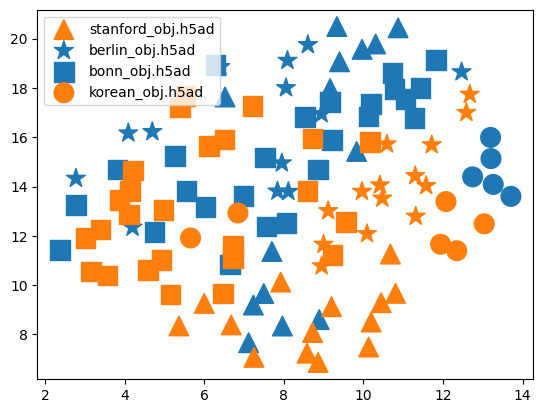

In [15]:
markers = ["o", "s", "*", "^"]
col_dict = {"Severe": "#ff7f0e", "Mild":"#1f77b4"}
plt.figure()
for study in adata_sample_emb.obs['study'].unique():
    adata_s = adata_sample_emb[adata_sample_emb.obs['study'] == study]
    cols = [col_dict[s] for s in list(adata_s.obs['condition'].values)]
    plt.scatter(adata_s.obsm['X_umap'][:,0], adata_s.obsm['X_umap'][:,1], c = cols, s = 200, label = study, marker = markers.pop())
plt.legend()
plt.savefig("./figures/umap_study.pdf")
plt.show()

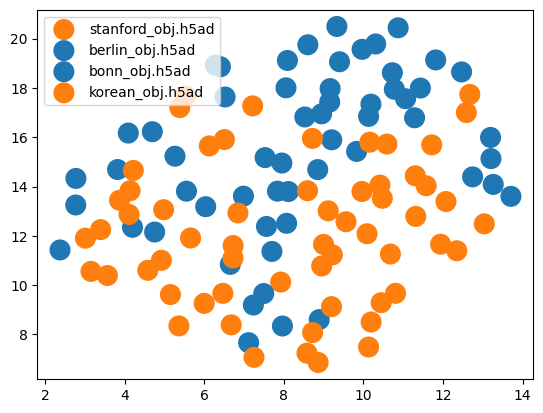

In [16]:
markers = ["o", "o", "o", "o"]
col_dict = {"Severe": "#ff7f0e", "Mild":"#1f77b4"}
plt.figure()
for study in adata_sample_emb.obs['study'].unique():
    adata_s = adata_sample_emb[adata_sample_emb.obs['study'] == study]
    cols = [col_dict[s] for s in list(adata_s.obs['condition'].values)]
    plt.scatter(adata_s.obsm['X_umap'][:,0], adata_s.obsm['X_umap'][:,1], c = cols, s = 200, label = study, marker = markers.pop())
plt.legend()
plt.savefig("./figures/umap.pdf")
plt.show()

### kNN

In [11]:
dis_label_int = [0 if i == 'Mild' else 1 for i in dis_label]
dis_label_int = np.array(dis_label_int)

study_labels = adata_sample_emb.obs['study']
study_labels_int = study_labels.astype('category').cat.codes.values

In [12]:
import sklearn.neighbors

embeds = np.array(sample_data_list)[:,0,:]
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(embeds, dis_label_int)
label_hat = knn.predict(embeds)
accuracy = (label_hat == dis_label_int).mean()

#embeds = np.array(sample_data_list)[:,0,:]
#knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
#knn.fit(embeds, dis_label_int)
#label_hat = most_frequent_per_row(dis_label_int[knn.kneighbors()[1]]) 
#accuracy = ( label_hat == dis_label_int).mean()
print(f" Accuracy of kNN for severity: {accuracy}")


knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
study_labels = adata_sample_emb.obs['study']
knn.fit(embeds, study_labels)
label_hat = knn.predict(embeds)
accuracy = (label_hat == study_labels).mean()
print(f" Accuracy of kNN for study: {accuracy}")

#knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
#knn.fit(embeds, study_labels_int)

#label_hat = most_frequent_per_row(study_labels_int[knn.kneighbors()[1]])
#accuracy = ( label_hat == study_labels_int).mean()
#print(f" Accuracy of kNN for study: {accuracy}")


 Accuracy of kNN for severity: 0.8793103448275862
 Accuracy of kNN for study: 0.8706896551724138


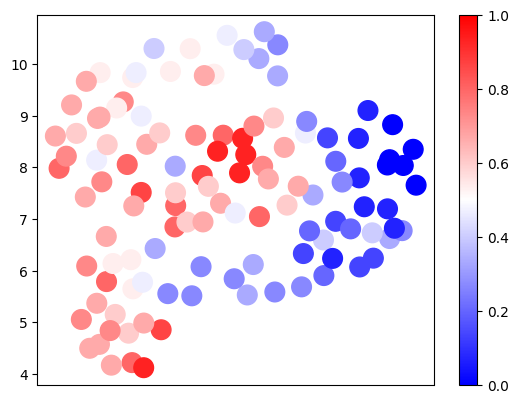

In [13]:
markers = ["o", "s", "*", "^"]
col_dict = {"Severe": "#ff7f0e", "Mild":"#1f77b4"}

knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=15)
knn.fit(adata_sample_emb.X, adata_sample_emb.obs['condition'])

plt.figure()
plt.scatter(adata_sample_emb.obsm['X_umap'][:,0], adata_sample_emb.obsm['X_umap'][:,1], c = knn.predict_proba(adata_sample_emb.X)[:,1], s = 200, label = study, cmap = "bwr", vmin = 0, vmax = 1)
plt.colorbar()
plt.xticks([])
#plt.savefig("./figures/umap_study.pdf")
plt.show()

### T-tests

In [14]:
adata_c_f_old = adata_c_f.copy()

In [16]:
adata_c_f_old.obs["celltype"].unique()

['Platelet cells', 'Plasmablasts', 'Classical monocytes', 'gd T cells', 'Intermediate monocytes', ..., 'Myeloid dendritic cells', 'CD8 T cells', 'Non classical monocytes', 'T regulatory cells', 'Plasmacytoid dendritic cells']
Length: 16
Categories (16, object): ['B cells', 'CD4 T cells', 'CD8 T cells', 'Classical monocytes', ..., 'Platelet cells', 'T regulatory cells', 'gd T cells', 'mixed']

/tmp/ipykernel_3051362/2864960273.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label_list.append(adata_s.obs['condition'][0])


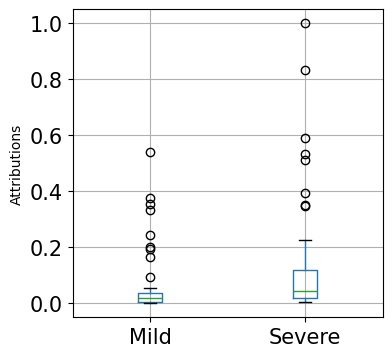

In [18]:

adata_c_f = adata_c_f_old[adata_c_f_old.obs['celltype'] == 'Non classical monocytes']
adata_c_f = adata_c_f_old[adata_c_f_old.obs['celltype'] == 'Myeloid dendritic cells']


attributions_list = []
approximation_error_list = []
label_list = []

if torch.cuda.is_available():
    for item in adata_c_f.obs['sampleID'].unique():
        adata_s = adata_c_f[adata_c_f.obs['sampleID'] == item]
        input_data = adata_s.X.toarray().reshape(1,  adata_s.X.shape[0], adata_s.X.shape[1])
        baselines = torch.FloatTensor(np.zeros_like(input_data)).to('cuda')
        query = torch.FloatTensor(input_data).to('cuda')
        attributions, approximation_error = ig.attribute(query,
                                                         baselines=baselines,
                                                         target=1,
                                                         return_convergence_delta=True)
        attributions_list.append(attributions.detach().to('cpu'))
        approximation_error_list.append(approximation_error.detach().to('cpu'))
        label_list.append(adata_s.obs['condition'][0])
        del input_data 
        del baselines
        del query
else:
    for item in adata_c_f.obs['sampleID'].unique():
        adata_s = adata_c_f[adata_c_f.obs['sampleID'] == item]
        input_data = adata_s.X.toarray().reshape(1,  adata_s.X.shape[0], adata_s.X.shape[1])
        baselines = torch.FloatTensor(np.zeros_like(input_data))
        query = torch.FloatTensor(input_data)
        attributions, approximation_error = ig.attribute(query,
                                                         baselines=baselines,
                                                         target=1,
                                                         return_convergence_delta=True)
        attributions_list.append(attributions.detach().to('cpu'))
        approximation_error_list.append(approximation_error.detach().to('cpu'))
        label_list.append(adata_s.obs['condition'][0])


gene_average = []
for i,j in zip(attributions_list,label_list):
    gene_average.append(i.cpu().numpy().mean(axis=1))




mean_set = np.array(gene_average).mean(axis=0)

matched_gene = []
for i in range(len(adata_c_f.var)):
    if adata_c_f.var_names[i] in adata.var_names:
        if mean_set[0][i] >0:
            matched_gene.append(i)



overall_average = []
for i,j in zip(attributions_list,label_list):
    overall_average.append(i.cpu().numpy()[:,:,matched_gene].mean())

scal = sklearn.preprocessing.MinMaxScaler()
overall_average = scal.fit_transform(np.array(overall_average).astype('float').reshape(-1,1))




healthy_average = []
disease_average = []
for i,j in zip(overall_average.T[0],label_list):
    if j == 'Mild':
        healthy_average.append(i)
    else:
        disease_average.append(i)
        

scipy.stats.ranksums(healthy_average, disease_average, alternative='less')
df1 = pd.DataFrame({'Mild':healthy_average})
df2 = pd.DataFrame({'Severe':disease_average})



df = pd.concat([df1, df2])


df.boxplot(figsize=(4,4), fontsize=15)
plt.ylabel('Attributions')
plt.savefig("./figures/attributions_covid.pdf")
plt.show()

RanksumsResult(statistic=-3.7982187913030265, pvalue=7.286982592589457e-05)

# pseudobulk

In [137]:
gene_list = pd.read_csv("/gstore/data/omni/scdb/cleaned_h5ads/gene_order.tsv", header=None)
gene_list = gene_list[0].values

import scanpy as sc
adata = sc.read_h5ad("/projects/site/gred/resbioai/liut61/combined_4dataset_processed_data.h5ad")

In [138]:
import numpy as np
def return_pseodubulk(adata, patient_info = 'patient_id', phen_key = 'Outcome'):
    data_list = []
    label_list = []
    study_list = []
    adata_c_f = adata
    for item in adata_c_f.obs[patient_info].unique():
        adata_s = adata_c_f[adata_c_f.obs[patient_info] == item]
        input_data = np.mean(adata_s.X.toarray(), axis=0)
        data_list.append(input_data)
        label_list.append(adata_s.obs[phen_key].values[0])
        study_list.append(adata_s.obs['sampleID'].values[0].split('/')[1])
    adata_out = sc.AnnData(np.array(data_list))
    adata_out.obs['Outcome'] = label_list
    adata_out.obs["study"] = study_list
    
    return adata_out

In [139]:
adata_out = return_pseodubulk(adata, patient_info = 'sampleID', phen_key = 'condition')

In [140]:
sc.pp.scale(adata_out)
sc.tl.pca(adata_out)

In [141]:
sc.pp.neighbors(adata_out)
sc.tl.umap(adata_out, min_dist = 1.5)
sc.tl.leiden(adata_out)

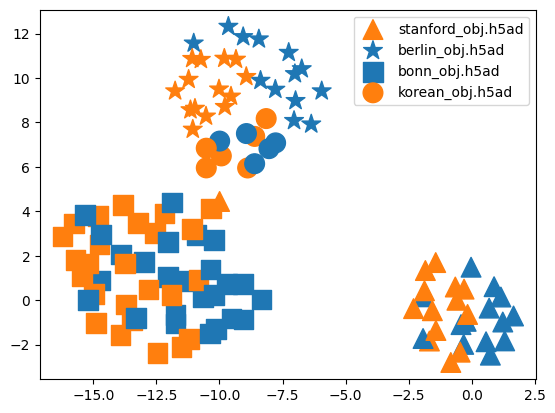

In [142]:
markers = ["o", "s", "*", "^"]
col_dict = {"Severe": "#ff7f0e", "Mild":"#1f77b4"}
plt.figure()
for study in adata_out.obs['study'].unique():
    adata_s = adata_out[adata_out.obs['study'] == study]
    cols = [col_dict[s] for s in list(adata_s.obs['Outcome'].values)]
    plt.scatter(adata_s.obsm['X_umap'][:,0], adata_s.obsm['X_umap'][:,1], c = cols, s = 200, label = study, marker = markers.pop())
plt.legend()
plt.savefig("./figures/umap_study.pdf")
plt.show()

In [58]:
adata_out

AnnData object with n_obs × n_vars = 116 × 18143
    obs: 'Outcome', 'study', 'leiden'
    var: 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

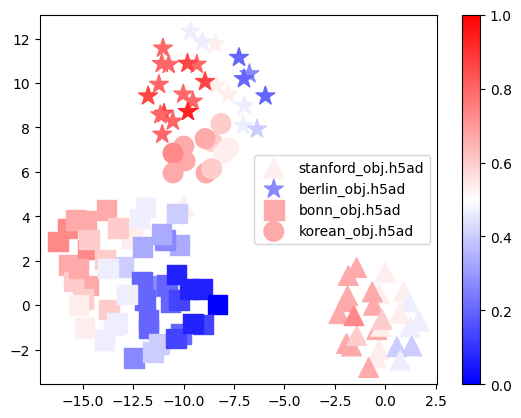

In [107]:
markers = ["o", "s", "*", "^"]
col_dict = {"Severe": "#ff7f0e", "Mild":"#1f77b4"}

knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=15)
knn.fit(adata_out.obsm["X_pca"], adata_out.obs['Outcome'])


markers = ["o", "s", "*", "^"]
col_dict = {"Severe": "#ff7f0e", "Mild":"#1f77b4"}
plt.figure()
for study in adata_out.obs['study'].unique():
    adata_s = adata_out[adata_out.obs['study'] == study]
    cols = [col_dict[s] for s in list(adata_s.obs['Outcome'].values)]
    plt.scatter(adata_s.obsm['X_umap'][:,0], adata_s.obsm['X_umap'][:,1], c = knn.predict_proba(adata_s.obsm["X_pca"])[:,1], s = 200, label = study, marker = markers.pop(), cmap = 'bwr', vmin = 0, vmax = 1)
plt.legend()
plt.colorbar()
#plt.savefig("./figures/umap_study.pdf")
plt.show()


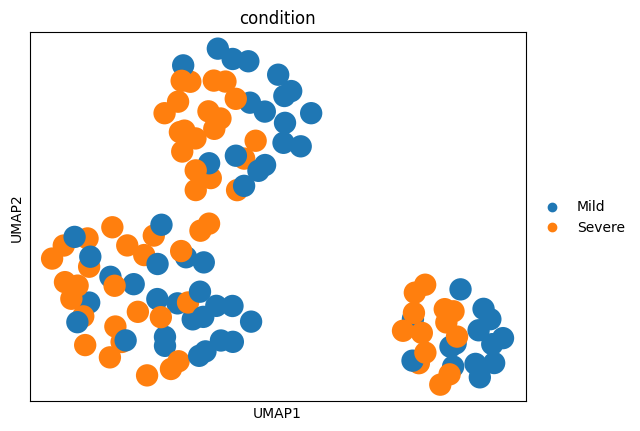

In [60]:
adata_out.obs['condition'] = list(adata_out.obs.Outcome)
sc.pl.umap(adata_out, color = 'condition')

In [61]:
adata_out.obs


,Outcome,study,leiden,condition
0,Severe,stanford_obj.h5ad,1,Severe
1,Severe,stanford_obj.h5ad,1,Severe
2,Mild,stanford_obj.h5ad,1,Mild
3,Severe,stanford_obj.h5ad,1,Severe
4,Severe,stanford_obj.h5ad,1,Severe
...,...,...,...,...
111,Severe,korean_obj.h5ad,0,Severe
112,Severe,korean_obj.h5ad,0,Severe
113,Severe,korean_obj.h5ad,0,Severe
114,Mild,korean_obj.h5ad,0,Mild


In [133]:
adata_out

AnnData object with n_obs × n_vars = 116 × 18143
    obs: 'Outcome', 'study', 'leiden'
    var: 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [80]:
embeds_bulk = adata_out.obsm["X_pca"]

severity_labels = adata_out.obs['Outcome'] 
severity_labels_int = [0 if i == 'Mild' else 1 for i in severity_labels]
severity_labels_int = np.array(severity_labels_int)

study_labels = adata_out.obs['study']
study_labels_int = study_labels.astype('category').cat.codes.values

In [106]:
import sklearn.neighbors

knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(adata_out.obsm["X_pca"], adata_out.obs["Outcome"])
label_hat = knn.predict(adata_out.obsm["X_pca"])
accuracy = (label_hat == adata_out.obs["Outcome"]).mean()
print(f" Accuracy of kNN for severity: {accuracy}")

knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
study_labels = adata_out.obs['study']
knn.fit(adata_out.obsm["X_pca"], study_labels)
label_hat = knn.predict(adata_out.obsm["X_pca"])
accuracy = (label_hat == study_labels).mean()
print(f"Accuracy of kNN for study : {accuracy}")

#knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
#knn.fit(embeds_bulk, severity_labels_int)
#label_hat = most_frequent_per_row(severity_labels_int[knn.kneighbors()[1]]) 
#accuracy = ( label_hat == severity_labels_int).mean()
#print(f" Accuracy of kNN for severity: {accuracy}")


#knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
#knn.fit(embeds_bulk, study_labels_int)
#label_hat = most_frequent_per_row(study_labels_int[knn.kneighbors()[1]])
#accuracy = ( label_hat == study_labels_int).mean()
#print(f" Accuracy of kNN for study: {accuracy}")

 Accuracy of kNN for severity: 0.7931034482758621
Accuracy of kNN for study : 0.9913793103448276
